# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
df = pd.read_csv('Data/insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Q1. Do smokers have higher insurance charges than non-smokers?

## Hypotheses

- Null Hypothesis ($H_0$): There is no difference in insurance charges between smokers and non-smokers.
- Alternative Hypothesis ($H_1$): There is a difference in insurance charges between smokers and non-smokers.

## Which Test

- 2 sample t-test
 - type: numerical
 - samples: 2 groups


## Separate Data

In [3]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
## Drop null values from related columns
smoker = df[df['smoker']== 'yes']
non_smoker = df[df['smoker']=='no']
smoker = smoker['charges']
non_smoker = non_smoker['charges']


## Assumptions

### Outliers

In [5]:
z_smoke = stats.zscore(smoker)
out_smoke = abs(z_smoke)>3
np.sum(out_smoke)

0

In [6]:
z_non_smoke = stats.zscore(non_smoker)
out_non_smoke = abs(z_non_smoke)>3
np.sum(out_non_smoke)

24

In [7]:
#remove outliers
non_smoker = non_smoker[(np.abs(stats.zscore(non_smoker))<3)]

### Normality

In [8]:
result_smoke = stats.normaltest(smoker)
result_smoke

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [9]:
result_non = stats.normaltest(non_smoker)
result_non

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

Both p-values are lower than the alpha value of 0.05 which means our data is NOT normally distributed, however the sample size is large enough to proceed.

### Equal Variance

In [10]:
# Test for equal variance
result = stats.levene(smoker, non_smoker)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

p-value is much smaller than 0.05 so we don't have equal variances. Just need to include equal_var=False

## Test

In [11]:
result = stats.ttest_ind(smoker, non_smoker, equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

pvalue much smaller than 0.05 so we reject the null hypothesis and accept there is a difference in insurance charges between smokers and non smokers. To see if smokers get higher charges we can look at the means.

## Visual

In [12]:
smoke_mean = smoker.mean()
non_mean = non_smoker.mean()
smoke_mean

32050.23183153284

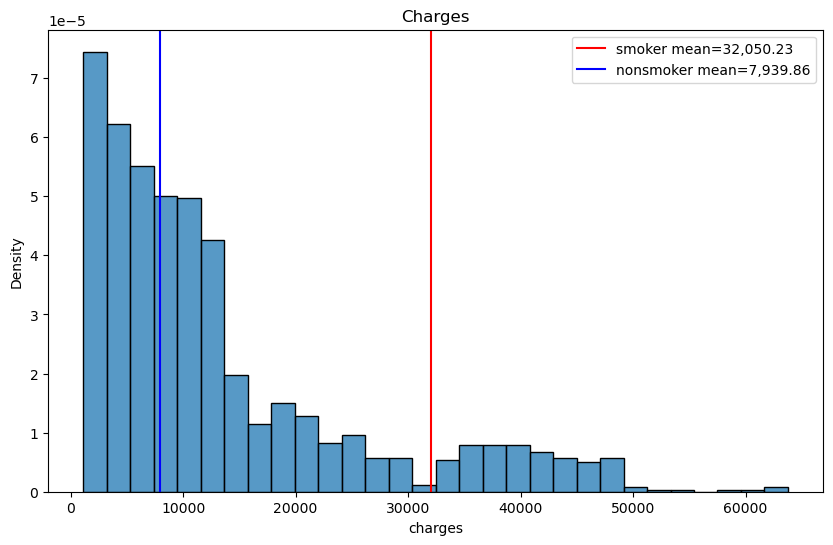

In [13]:
fig,ax = plt.subplots(figsize = (10,6))
sns.histplot(df['charges'], stat='density')
ax.axvline(smoke_mean, color='red', label=f'smoker mean={smoke_mean:,.2f}')
ax.axvline(non_mean, color = 'blue', label=f'nonsmoker mean={non_mean:,.2f}')
ax.set_title('Charges')
ax.legend();

As shown in the graph, the charges mean of 32k is much higher than 8k meaning that smokers get charged much more than nonsmokers. 

# Q2. Are men more likely to smoke than women?

## Hypotheses

- Null Hypothesis ($H_0$): The likelihood of smoking between men and women show no significant difference.
- Alternative Hypothesis ($H_1$): The likelihood of smoking between men and women.

## Which Test

- Chi-Square
 - type: Categorical
 - samples: 2 groups


## Separate Data

In [14]:
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


## Assumptions

### Outcome binary
- yes or no outcome

### Trials/observations Independent
- yes, they are independent

## Test

In [15]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result
print(p)
p<.05

0.006548143503580696


True

pvalue is less than 0.05 so we reject the null hypothesis meaning that there is a signigicant difference in smoking frequency between men and females. Can look if men smoke more than women with barplot.

## Visual

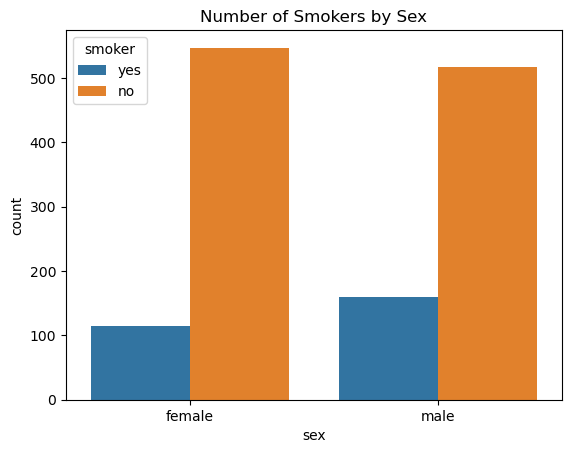

In [16]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

More males smoke than females.

# Q3. Do different regions have different charges, on average?

## Hypotheses

- Null Hypothesis ($H_0$): There is no difference in charges between regions.
- Alternative Hypothesis ($H_1$): There is a significant difference in charges between regions.

## Which Test

In [17]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

- ANOVA and/or Tukey
 - type: numerica
 - samples: multiple (4)

## Separate Data

In [18]:
southwest = df.loc[df['region']=='southwest', 'charges']
southeast = df.loc[df['region']=='southeast', 'charges']
northwest = df.loc[df['region']=='northwest', 'charges']
northeast = df.loc[df['region']=='northeast', 'charges']

In [19]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Assumptions

### Outliers

In [20]:
zscores= stats.zscore(groups['southwest'])
outliers = abs(zscores)>3
np.sum(outliers)

8

In [21]:
groups['southwest'] = groups['southwest'][(np.abs(stats.zscore(groups['southwest'])) < 3)]

In [22]:
zscores= stats.zscore(groups['southeast'])
outliers = abs(zscores)>3
np.sum(outliers)

2

In [23]:
groups['southeast'] = groups['southeast'][(np.abs(stats.zscore(groups['southeast'])) < 3)]

In [24]:
zscores= stats.zscore(groups['northwest'])
outliers = abs(zscores)>3
np.sum(outliers)

7

In [25]:
groups['northwest'] = groups['northwest'][(np.abs(stats.zscore(groups['northwest'])) < 3)]

In [26]:
zscores= stats.zscore(groups['northeast'])
outliers = abs(zscores)>3
np.sum(outliers)

4

In [27]:
groups['northeast'] = groups['northeast'][(np.abs(stats.zscore(groups['northeast'])) < 3)]

### Normality

In [28]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


In [29]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,317.0,7.728611e-22,97.223886,True
southeast,362.0,1.936990e-13,58.544942,True
northwest,318.0,2.940543e-19,85.341045,True
northeast,320.0,3.557877e-17,75.749565,True


No groups have a normal distribution, but can be ignored as sample sizes are big enough

### Equal Variance

In [30]:
stats.levene(*groups.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

pvalue is lower than 0.05 so we set equal_var to false.

## Test

In [31]:
result = stats.f_oneway(*groups.values())
result

F_onewayResult(statistic=5.496394682506454, pvalue=0.0009419710075537749)

pvalue is lower than 0.05 so we reject the null hypothesis meaning there is a significant difference in charges between regions. Will use Tukeys for further observation.

## Tukeys

In [32]:
values = df['charges']
labels = df['region']
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


According to the Tukeys test there is only a significant difference in charges between the southeast and southwest regions which can be shown in the graph below.

## Visual

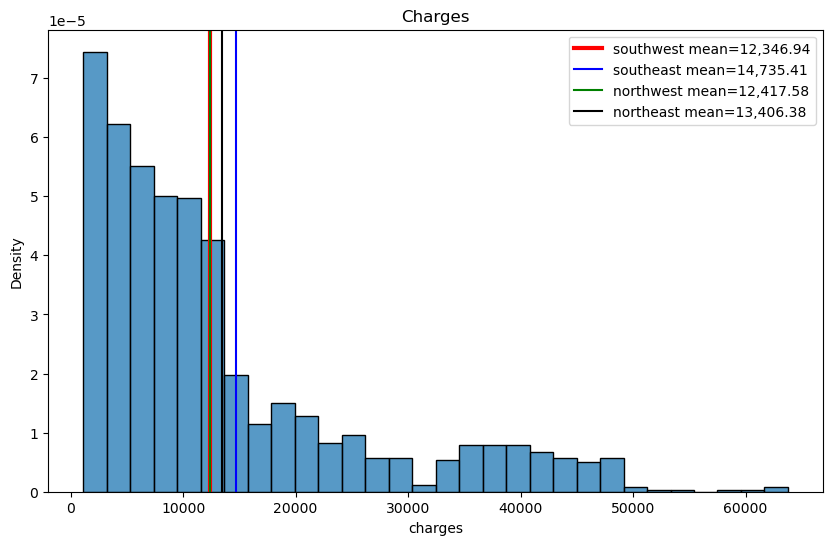

In [37]:
sw_mean = southwest.mean()
se_mean = southeast.mean()
nw_mean = northwest.mean()
ne_mean = northeast.mean()
fig,ax = plt.subplots(figsize = (10,6))
sns.histplot(df['charges'], stat='density')
ax.axvline(sw_mean, lw = 3, color='red', label=f'southwest mean={sw_mean:,.2f}')
ax.axvline(se_mean, color = 'blue', label=f'southeast mean={se_mean:,.2f}')
ax.axvline(nw_mean, color = 'green', label=f'northwest mean={nw_mean:,.2f}')
ax.axvline(ne_mean, color = 'black', label=f'northeast mean={ne_mean:,.2f}')
ax.set_title('Charges')
ax.legend();